In [1]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2 as cv
import torch
import torch.nn as nn
from tqdm import tqdm
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install ultralytics

In [3]:
import ultralytics
from ultralytics import YOLO
from ultralytics.nn.modules import C2f
from ultralytics.nn.modules.conv import Conv


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Training on {device}')

model = YOLO('yolov8n.pt').to(device)

Training on cuda


In [48]:
model.info(True)

layer                                     name  gradient   parameters                shape         mu      sigma
    0                      model.0.conv.weight     False          432        [16, 3, 3, 3]   -0.00279      0.152 torch.float32
    1                        model.0.bn.weight     False           16                 [16]       2.97       1.86 torch.float32
    2                          model.0.bn.bias     False           16                 [16]      0.249       4.17 torch.float32
    3                      model.1.conv.weight     False         4608       [32, 16, 3, 3]   -0.00012      0.063 torch.float32
    4                        model.1.bn.weight     False           32                 [32]       5.02       1.12 torch.float32
    5                          model.1.bn.bias     False           32                 [32]      0.942        1.5 torch.float32
    6                  model.2.cv1.conv.weight     False         1024       [32, 32, 1, 1]     -0.011     0.0906 torch.float3

(225, 3157200, 0, 8.8575488)

In [5]:
backbone = model.model.model
new_layers = nn.Sequential(
    *list(backbone[:6]),
    Conv(128, 256, 3, 2),
    C2f(256, 256, 1),
    Conv(256, 512, 3, 2),
    C2f(512, 512, 1),
    *list(backbone[9:])
).to('cuda:0')

model.model.model = new_layers


In [6]:
for param in model.model.model.parameters():
    param.requires_grad = True

In [7]:
model.info(True)

layer                                     name  gradient   parameters                shape         mu      sigma
    0                      model.0.conv.weight      True          432        [16, 3, 3, 3]   -0.00279      0.152 torch.float32
    1                        model.0.bn.weight      True           16                 [16]       2.97       1.86 torch.float32
    2                          model.0.bn.bias      True           16                 [16]      0.249       4.17 torch.float32
    3                      model.1.conv.weight      True         4608       [32, 16, 3, 3]   -0.00012      0.063 torch.float32
    4                        model.1.bn.weight      True           32                 [32]       5.02       1.12 torch.float32
    5                          model.1.bn.bias      True           32                 [32]      0.942        1.5 torch.float32
    6                  model.2.cv1.conv.weight      True         1024       [32, 32, 1, 1]     -0.011     0.0906 torch.float3

(222, 5978320, 5978320, 0.0)

In [8]:
results = model.train(data='/content/drive/MyDrive/YOLO_detection/weapon_data/data.yaml',
        epochs= 120,
        imgsz=640,
        batch=32,
        augment=True,
        visualize=True,
        single_cls = True)

engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/YOLO_detection/weapon_data/data.yaml, epochs=120, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=True, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras

train: Scanning /content/drive/MyDrive/YOLO_detection/weapon_data/labels/train.cache... 78 images, 0 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/YOLO_detection/weapon_data/labels/val.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      4.23G      4.718      7.554      4.266         25        640: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      4.23G      4.297        7.2      4.249         32        640: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      4.21G      4.452      7.393      4.257         25        640: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      4.21G      4.706      8.223      4.311         29        640: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      4.24G      4.545      6.799      4.198         24        640: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      4.21G      4.409      6.508       4.15         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      4.21G      4.307      6.213       4.09         37        640: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120      4.21G      3.994      6.164      4.074         28        640: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120      4.21G      3.953      6.266      4.034         25        640: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      4.24G      3.953      5.379      3.818         34        640: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      4.21G      3.549      5.233      3.841         31        640: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      4.21G       4.02      5.516       3.74         24        640: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      4.24G      3.386      4.519       3.56         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      4.21G      3.441      4.633       3.36         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120      4.21G      3.519      4.547      3.202         29        640: 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      4.21G      3.315      4.217      3.106         28        640: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      4.21G      3.224      4.101       3.14         28        640: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      4.22G      3.294      3.908      3.021         26        640: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      4.21G      3.396      3.804      2.919         27        640: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.58it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      4.25G      3.287      3.752      2.846         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      4.21G      2.922      3.486      2.953         26        640: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      4.22G      3.093      3.536      2.832         27        640: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      4.21G      2.955      3.269      2.692         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

                   all         10         10          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      4.25G      3.117      3.306      2.942         26        640: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

                   all         10         10   0.000501        0.1   0.000467   4.67e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      4.21G      2.917      3.255      2.634         30        640: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         10         10   0.000498        0.1   0.000463   4.63e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      4.22G      3.064      2.905      2.612         33        640: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         10         10   0.000984        0.2   0.000731   0.000165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      4.24G      2.823      2.832       2.35         26        640: 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]

                   all         10         10    0.00148        0.3    0.00107   0.000274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120      4.25G      2.924      2.959      2.526         22        640: 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


                   all         10         10    0.00148        0.3    0.00107   0.000227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      4.21G       2.83      2.783      2.562         25        640: 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         10         10    0.00146        0.3     0.0117    0.00254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      4.22G      2.701      2.565      2.458         28        640: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


                   all         10         10    0.00192        0.4    0.00188   0.000972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      4.21G      2.674      2.584      2.454         27        640: 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

                   all         10         10     0.0032        0.7     0.0518     0.0164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120      4.22G      2.749      2.674      2.586         38        640: 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         10         10    0.00324        0.8      0.102     0.0322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      4.21G      2.516      2.563      2.421         30        640: 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         10         10    0.00327        0.8      0.063     0.0194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      4.22G      2.564      2.483      2.285         34        640: 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         10         10      0.438        0.1      0.159     0.0395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      4.21G      2.729      2.432      2.294         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         10         10      0.392        0.1      0.174     0.0688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      4.25G      2.573      2.338      2.254         28        640: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         10         10      0.458        0.1      0.261     0.0893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      4.23G      2.541       2.25      2.285         38        640: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


                   all         10         10      0.427        0.1      0.195     0.0494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      4.25G      2.679      2.259      2.385         31        640: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all         10         10      0.512        0.2      0.214     0.0517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      4.24G      2.539      2.194      2.257         31        640: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         10         10      0.395        0.3      0.242     0.0538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      4.22G      2.467      2.144      2.268         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         10         10      0.335        0.3      0.157     0.0684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      4.21G       2.57      2.091      2.221         33        640: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all         10         10      0.348        0.3      0.135     0.0498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      4.22G      2.473       2.16      2.249         28        640: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]

                   all         10         10      0.606        0.2      0.229     0.0351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      4.21G      2.458      2.077        2.1         32        640: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         10         10      0.359        0.3      0.151      0.028



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      4.22G      2.451       2.02      2.187         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]

                   all         10         10      0.406        0.3      0.137     0.0416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      4.21G      2.287      1.943      1.948         33        640: 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all         10         10      0.465        0.3      0.195     0.0401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      4.22G      2.349      1.826      1.984         38        640: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]

                   all         10         10      0.189        0.2      0.203     0.0594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      4.21G      2.366      1.823      1.978         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

                   all         10         10       0.35        0.3      0.238     0.0729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      4.25G      2.214      1.815      1.937         34        640: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         10         10      0.416        0.5      0.292     0.0871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      4.21G      2.383      1.904      1.999         32        640: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         10         10      0.452        0.3      0.268     0.0669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      4.22G      2.277      1.847      2.055         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

                   all         10         10      0.282        0.4      0.285     0.0732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      4.21G       2.23      1.747      1.969         31        640: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         10         10      0.192        0.3      0.179     0.0605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      4.25G      2.272      1.789      2.013         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.17it/s]

                   all         10         10      0.596      0.296      0.308     0.0566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      4.21G      2.343       1.76      1.922         37        640: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         10         10      0.487        0.2      0.235     0.0795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      4.22G      2.297       1.74      2.007         32        640: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         10         10        0.2        0.3      0.138     0.0362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      4.23G      2.142      1.689      1.944         36        640: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


                   all         10         10        0.3        0.1     0.0823     0.0215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120      4.22G      2.082      1.795      1.986         36        640: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         10         10      0.141      0.166     0.0965     0.0336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120      4.21G      2.086       1.59      1.821         25        640: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         10         10      0.282        0.4       0.21     0.0579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      4.22G      2.153      1.654      2.005         25        640: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         10         10      0.307        0.3      0.348     0.0927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      4.21G      2.035       1.61      1.809         26        640: 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

                   all         10         10       0.19        0.4      0.224     0.0732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      4.22G      2.204      1.682      1.896         23        640: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


                   all         10         10       0.22        0.3       0.15      0.046

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      4.21G      2.005      1.635      1.691         22        640: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         10         10      0.322        0.2      0.147     0.0323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      4.22G      2.105      1.607      1.792         35        640: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


                   all         10         10     0.0856        0.2      0.093     0.0274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      4.21G       2.27      1.711      1.974         23        640: 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         10         10      0.315        0.2      0.143      0.035



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      4.22G      2.121       1.64      1.892         27        640: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         10         10      0.317        0.4      0.214     0.0714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      4.21G      2.034      1.542      1.811         27        640: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         10         10       0.43        0.4      0.217     0.0577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      4.22G       2.05       1.59      1.816         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all         10         10      0.944        0.3      0.379      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      4.21G      1.898      1.425      1.632         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         10         10      0.747        0.3      0.385      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      4.22G      1.979      1.626      1.803         29        640: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


                   all         10         10      0.417        0.5      0.534      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      4.21G      1.776      1.374      1.628         33        640: 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         10         10      0.394      0.522       0.52      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      4.22G      1.815      1.437      1.711         26        640: 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


                   all         10         10      0.274        0.5      0.277     0.0656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      4.21G      1.846      1.447      1.713         27        640: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all         10         10      0.261      0.388      0.252     0.0707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      4.22G      1.778      1.407      1.709         28        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         10         10      0.269        0.3       0.28     0.0716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      4.21G      1.865       1.41      1.756         27        640: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]

                   all         10         10      0.356        0.4      0.188     0.0662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      4.25G      1.842      1.394      1.647         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

                   all         10         10      0.494        0.3      0.361     0.0952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      4.21G      1.732      1.384      1.651         24        640: 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         10         10      0.448        0.4      0.396        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      4.25G       1.75      1.367      1.662         28        640: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


                   all         10         10      0.531        0.5      0.487      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120      4.21G      1.835      1.332      1.628         29        640: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         10         10      0.778        0.3       0.44       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      4.25G      1.772      1.301      1.595         31        640: 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all         10         10      0.356        0.5      0.397      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      4.23G      1.851       1.38      1.606         27        640: 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         10         10       0.53      0.453      0.471      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      4.22G      1.756      1.379       1.59         28        640: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         10         10      0.447      0.326      0.277     0.0967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      4.21G      1.852      1.337       1.62         24        640: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

                   all         10         10      0.456        0.4      0.258     0.0973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      4.25G      1.751      1.345      1.652         32        640: 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.89it/s]

                   all         10         10      0.798        0.4      0.476      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120      4.21G      1.791      1.356      1.673         24        640: 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all         10         10      0.653        0.4      0.449     0.0974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      4.22G      1.632      1.355      1.598         20        640: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]


                   all         10         10      0.407        0.3      0.234     0.0718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      4.21G      1.799      1.305      1.661         29        640: 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         10         10      0.423      0.294      0.207     0.0699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      4.22G      1.756       1.38      1.677         19        640: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

                   all         10         10      0.147        0.2      0.148     0.0482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120      4.21G      1.727      1.288      1.563         33        640: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         10         10      0.311        0.3      0.204     0.0624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      4.25G      1.626      1.201      1.536         31        640: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         10         10      0.426        0.4        0.4     0.0989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      4.21G      1.637      1.265      1.623         27        640: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


                   all         10         10      0.486      0.475      0.456      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      4.22G      1.608      1.155      1.488         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         10         10      0.346        0.4      0.222     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120      4.24G      1.706      1.249      1.488         33        640: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

                   all         10         10      0.483        0.4      0.441     0.0965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120      4.25G      1.704      1.212      1.565         37        640: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         10         10      0.545       0.48      0.502      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      4.21G      1.667      1.298      1.648         26        640: 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         10         10        0.4      0.399       0.29      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120      4.22G       1.65      1.171       1.58         30        640: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all         10         10       0.57      0.398      0.476      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      4.23G      1.669      1.185      1.522         25        640: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         10         10      0.482        0.4      0.495      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      4.22G      1.714      1.233      1.606         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         10         10      0.439        0.5      0.458      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      4.21G      1.439      1.148       1.39         32        640: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

                   all         10         10      0.436        0.5      0.481      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120      4.22G      1.633      1.267      1.603         29        640: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


                   all         10         10       0.93        0.3      0.478      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      4.21G      1.567      1.141       1.52         27        640: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all         10         10      0.938        0.3      0.473      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120      4.22G      1.472      1.096      1.514         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]


                   all         10         10      0.343        0.6      0.427     0.0962

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      4.21G      1.475      1.114      1.447         22        640: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         10         10      0.284        0.5      0.336      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      4.22G      1.566      1.144      1.594         26        640: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         10         10      0.293        0.5      0.337      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      4.21G      1.554       1.21      1.491         30        640: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         10         10      0.442        0.6      0.438      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      4.22G      1.685      1.253      1.656         30        640: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         10         10      0.452      0.663       0.49      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      4.24G      1.451      1.111      1.416         34        640: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         10         10      0.458      0.676       0.52      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      4.22G      1.525      1.142      1.452         26        640: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         10         10      0.482      0.654      0.553       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      4.21G      1.607      1.144      1.487         24        640: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

                   all         10         10       0.48      0.648      0.574      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      4.22G      1.595      1.139       1.48         38        640: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         10         10      0.421      0.584      0.516      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      4.21G       1.46      1.078      1.419         33        640: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]

                   all         10         10      0.452      0.579      0.516       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      4.22G       1.49      1.095      1.422         24        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         10         10      0.375      0.541      0.464     0.0975


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120      4.21G      1.484      1.331      1.528         14        640: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         10         10      0.382        0.5      0.452     0.0944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      4.22G      1.409       1.23      1.467         14        640: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         10         10      0.509        0.5       0.45     0.0843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      4.21G      1.325      1.197      1.453         15        640: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

                   all         10         10        0.5        0.5      0.452     0.0923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      4.22G      1.399      1.197      1.476         14        640: 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]


                   all         10         10      0.488        0.4      0.297      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      4.21G      1.404      1.167      1.466         14        640: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         10         10      0.509        0.4      0.296      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      4.22G      1.416      1.186      1.439         16        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         10         10      0.557        0.4      0.333      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      4.21G      1.466      1.204      1.395         14        640: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all         10         10      0.453        0.4      0.319      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      4.22G       1.31      1.187      1.423         15        640: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]

                   all         10         10      0.553        0.5      0.531      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      4.21G       1.43      1.167      1.453         16        640: 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


                   all         10         10      0.489        0.5      0.522       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      4.22G      1.309      1.113      1.442         16        640: 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         10         10      0.465        0.5      0.481      0.104



120 epochs completed in 0.088 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.9 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 186 layers, 2,684,563 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


                   all         10         10      0.901        0.4      0.546       0.16
Speed: 0.2ms preprocess, 24.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train


In [9]:
print("Precision\t  Recall\tmAP50\t\tmAP95")
results.class_result(0)

Precision	  Recall	mAP50		mAP95


(0.9013168340754548, 0.4, 0.54617206548241, 0.16028165697240476)

In [12]:
predictions = model.predict(source="/content/drive/MyDrive/YOLO_detection/weapon_data/images/test")



image 1/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im16.jpg: 640x640 (no detections), 29.6ms
image 2/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im2.jpg: 640x640 1 Guns, 26.5ms
image 3/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im31.jpg: 640x640 (no detections), 44.0ms
image 4/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im33.jpg: 640x640 (no detections), 27.0ms
image 5/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im45.jpg: 640x640 1 Guns, 25.9ms
image 6/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im61.jpg: 640x640 (no detections), 28.5ms
image 7/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im62.jpg: 640x640 1 Guns, 25.6ms
image 8/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im64.jpg: 640x640 (no detections), 24.5ms
image 9/10 /content/drive/MyDrive/YOLO_detection/weapon_data/images/test/im66.jpg: 640x640 (no detections),

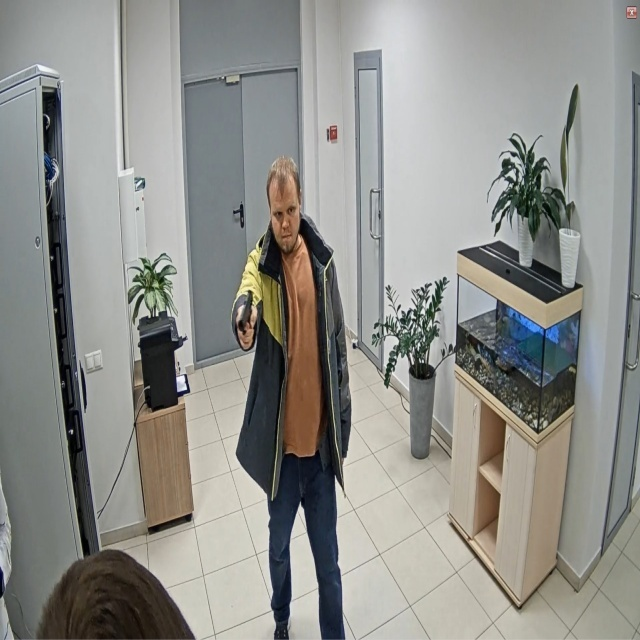

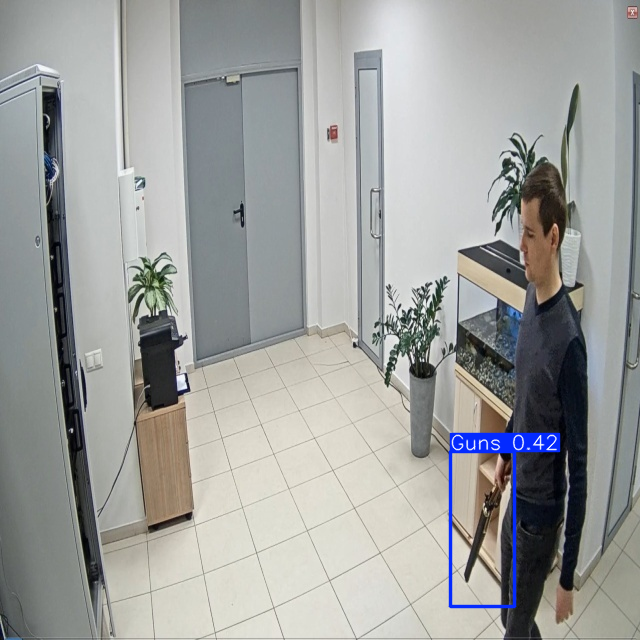

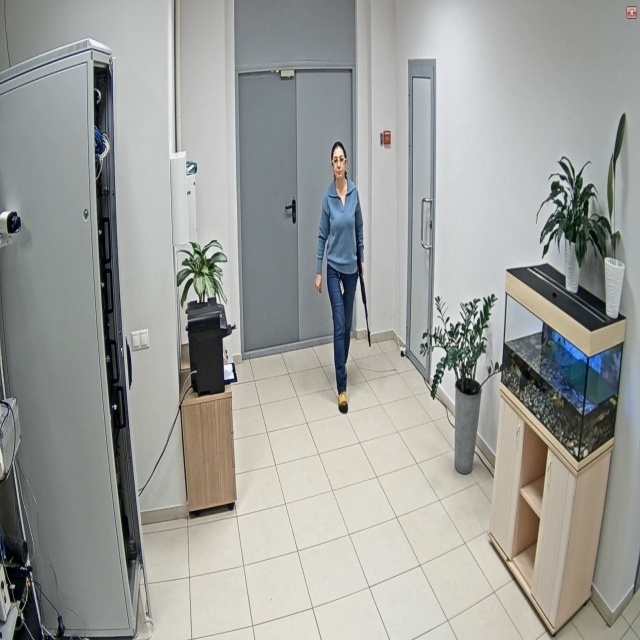

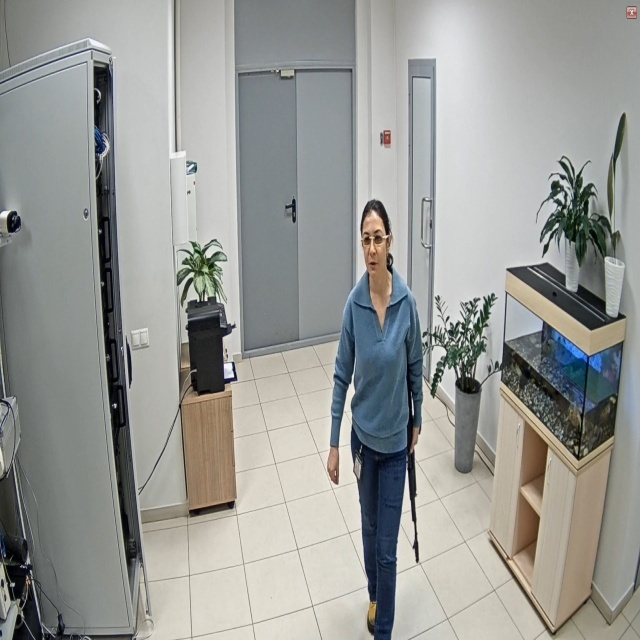

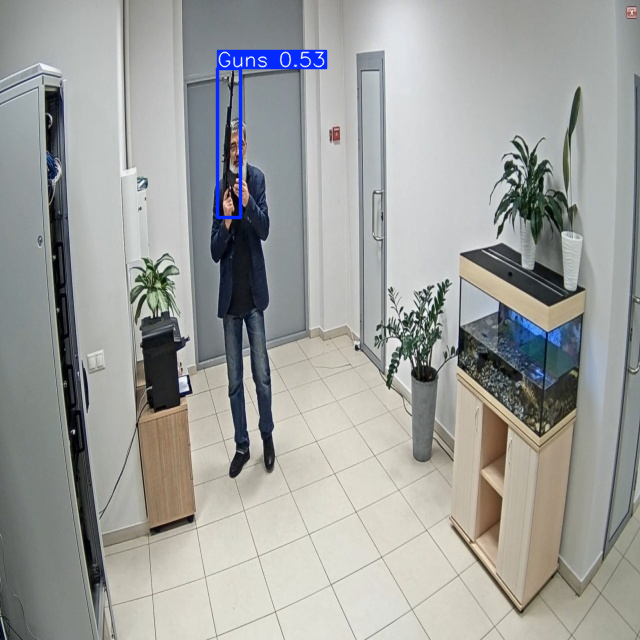

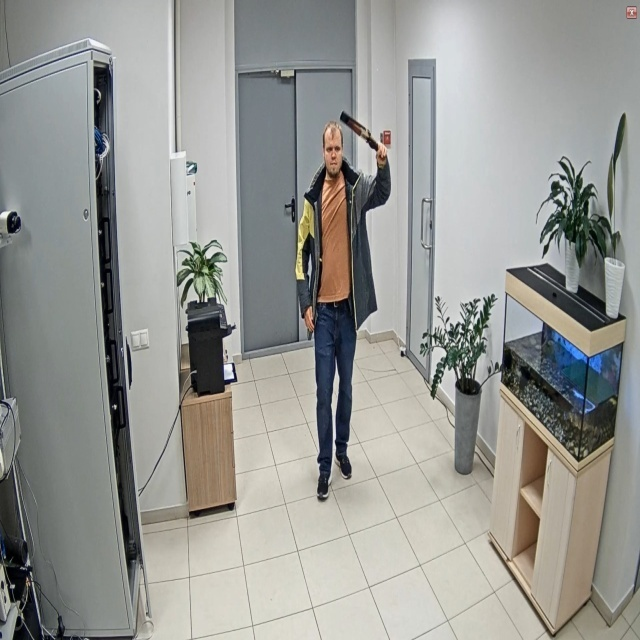

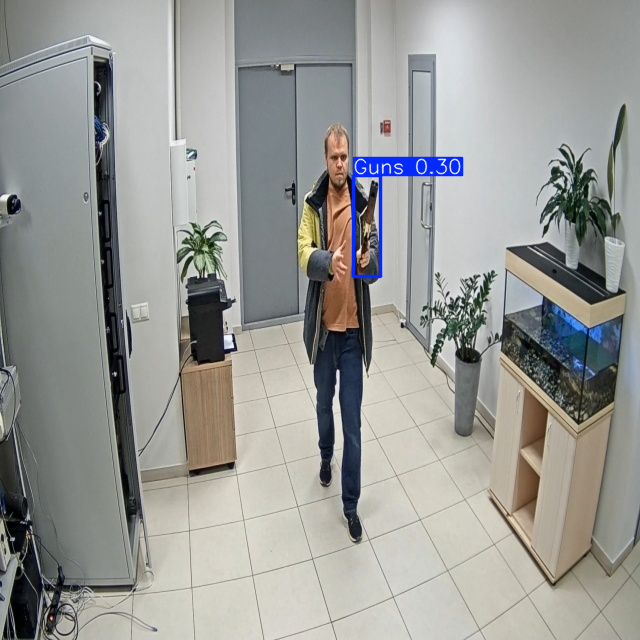

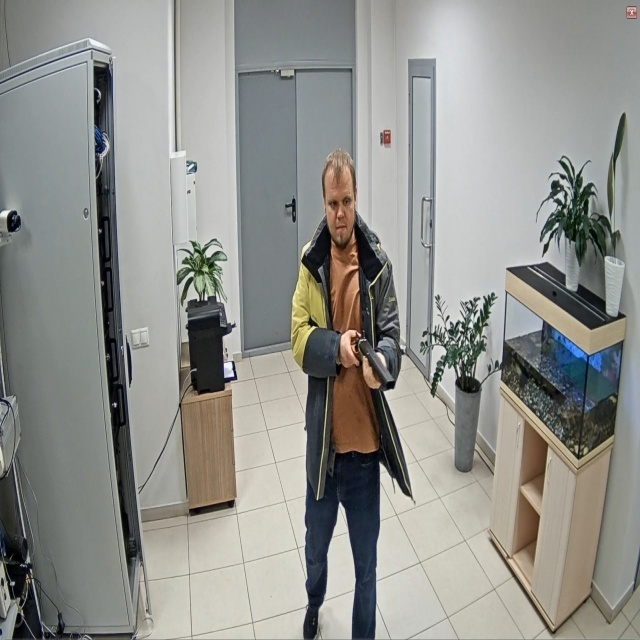

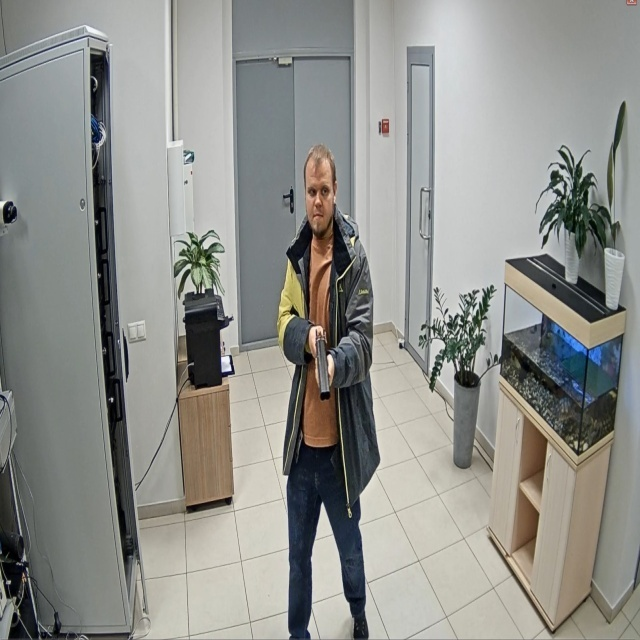

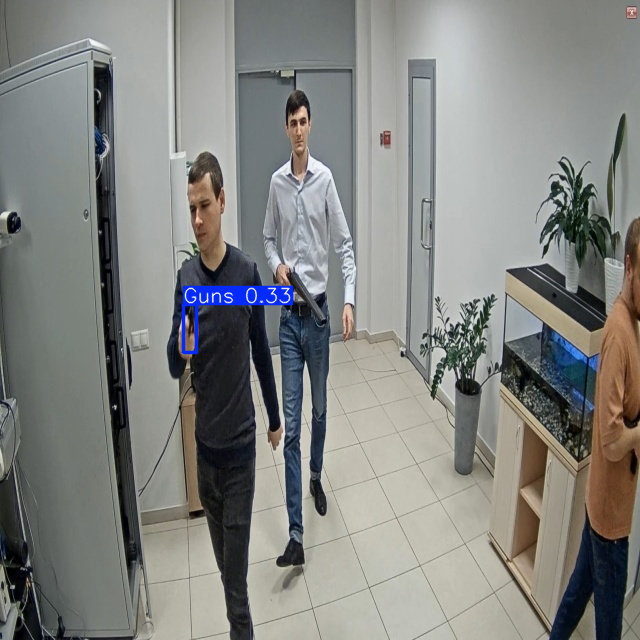

In [13]:
for result in predictions:
    result.show()